# 图像分类数据集（Fashion-MNIST）

在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST [1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST [2]。

## 获取数据集

首先导入本节需要的包或模块。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

下面，我们通过Gluon的`data`包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数`train`来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

训练集中和测试集中的每个类别的图像数分别为6,000和1,000。因为有10个类别，所以训练集和测试集的样本数分别为60,000和10,000。

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

我们可以通过方括号`[]`来访问任意一个样本，下面获取第一个样本的图像和标签。

In [4]:
feature, label = mnist_train[0]

变量`feature`对应高和宽均为28像素的图像。每个像素的数值为0到255之间8位无符号整数（uint8）。它使用3维的NDArray储存。其中的最后一维是通道数。因为数据集中是灰度图像，所以通道数为1。为了表述简洁，我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`（h，w）`。

In [5]:
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

图像的标签使用NumPy的标量表示。它的类型为32位整数。

In [6]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

Fashion-MNIST中一共包括了10个类别，分别为：t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [7]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [8]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

现在，我们看一下训练数据集中前9个样本的图像内容和文本标签。

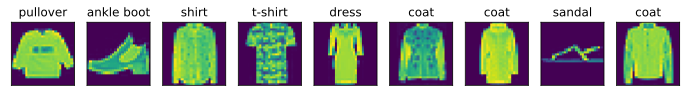

In [9]:
X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。虽然我们可以像[“线性回归的从零开始实现”](linear-regression-scratch.md)一节中那样通过`yield`来定义读取小批量数据样本的函数，但为了代码简洁，这里我们直接创建`DataLoader`实例。该实例每次读取一个样本数为`batch_size`的小批量数据。这里的批量大小`batch_size`是一个超参数。

在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。Gluon的`DataLoader`中一个很方便的功能是允许使用多进程来加速数据读取（暂不支持Windows操作系统）。这里我们通过参数`num_workers`来设置4个进程读取数据。

此外，我们通过`ToTensor`类将图像数据从uint8格式变换成32位浮点数格式，并除以255使得所有像素的数值均在0到1之间。`ToTensor`类还将图像通道从最后一维移到最前一维来方便之后介绍的卷积神经网络计算。通过数据集的`transform_first`函数，我们将`ToTensor`的变换应用在每个数据样本（图像和标签）的第一个元素，即图像之上。

In [10]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                              batch_size, shuffle=True,
                              num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                             batch_size, shuffle=False,
                             num_workers=num_workers)

我们将获取并读取Fashion-MNIST数据集的逻辑封装在`d2lzh.load_data_fashion_mnist`函数中供后面章节调用。该函数将返回`train_iter`和`test_iter`两个变量。随着本书内容的不断深入，我们会进一步改进该函数。它的完整实现将在[“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.md)一节中描述。

最后我们查看读取一遍训练数据需要的时间。

In [11]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'1.22 sec'

## 小结

* Fashion-MNIST是一个10类服饰分类数据集，之后章节里我们将使用它来检验不同算法的表现。
* 我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`（h，w）`。

## 练习

* 减小`batch_size`（例如到1）会影响读取性能吗？
* 非Windows用户请尝试修改`num_workers`来查看它对读取性能的影响。
* 查看MXNet文档，`gdata.vision`里还提供了哪些别的数据集？
* 查看MXNet文档，`gdata.vision.transforms`还提供了哪些别的变换方法？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7760)

![](../img/qr_fashion-mnist.svg)


## 参考文献

[1] LeCun, Y., Cortes, C., & Burges, C. http://yann.lecun.com/exdb/mnist/

[2] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.